In [ ]:
!nvidia-smi

Wed Dec 22 00:53:47 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Clone repo

In [ ]:
!git clone https://github.com/kaylode/tern.git main 
%cd main

Cloning into 'main'...
remote: Enumerating objects: 1207, done.
remote: Counting objects: 100% (1207/1207), done.
remote: Compressing objects: 100% (451/451), done.
remote: Total 1207 (delta 733), reused 1206 (delta 732), pack-reused 0
Receiving objects: 100% (1207/1207), 192.66 KiB | 13.76 MiB/s, done.
Resolving deltas: 100% (733/733), done.
/content/main


In [ ]:
!git reset --hard HEAD
!git pull

HEAD is now at c8ec54a clean stuffs
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 7 (delta 5), reused 7 (delta 5), pack-reused 0
Unpacking objects: 100% (7/7), done.
From https://github.com/kaylode/tern
   c8ec54a..23f8068  master     -> origin/master
Updating c8ec54a..23f8068
Fast-forward
 modules/models/__init__.py         | 2 +-
 modules/models/encoder/__init__.py | 4 ++--
 2 files changed, 3 insertions(+), 3 deletions(-)


## Install requirements

In [ ]:
%%capture
!pip install -r requirements.txt
!apt install libomp-dev
!pip install faiss-gpu

## Download data

In [ ]:
%%capture
!mkdir /content/data

# flickr30k images
!gdown https://drive.google.com/uc?id=1OvjIaL3M8g23C5xCebTylNaq4KxbOu0U -O /content/data/data.zip 
!unzip /content/data/data.zip  -d /content/data
!rm -rf /content/data/data.zip

# flickr30k annotations
!gdown https://drive.google.com/uc?id=1mcNRnd7Wf2NnoJuaZJW09WEQtaBfeaDJ -O /content/data/annotations.zip 
!unzip /content/data/annotations.zip  -d /content/data
!rm -rf /content/data/annotations.zip

# Pre-extracted Bottom-Up attention features
!gdown https://drive.google.com/uc?id=1YVQZ2UzGRPf8GEV0CYPohivL7veffb9p -O /content/data/bottomup.zip 
!unzip /content/data/bottomup.zip  -d /content/data
!rm -rf /content/data/bottomup.zip

# Pre-extracted BERT features
!gdown https://drive.google.com/uc?id=1UIr0PfYwOst1VNT8rhph8NyVNziy78P5 -O /content/data/bert.zip 
!unzip /content/data/bert.zip  -d /content/data
!rm -rf /content/data/bert.zip

## Visualize data

In [ ]:
%cd main
from datasets import CocoDataset

dataset = CocoDataset(
    root_dir="/content/data/flickr30k_images/flickr30k_images", 
    ann_path="/content/data/val.json", 
    image_size=224, 
    keep_ratio=False)

/content/main
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


1. A rocker standing with one foot on the stage holding the microphone attached to the stand over his head.
2. A man plays a guitar while another man swings his head down while holding tight to a microphone.
3. A standing man holds a microphone in front of a man holding a guitar.
4. A member of a band is jamming out on stage while performing a song.
5. The band is setting up for their performance.


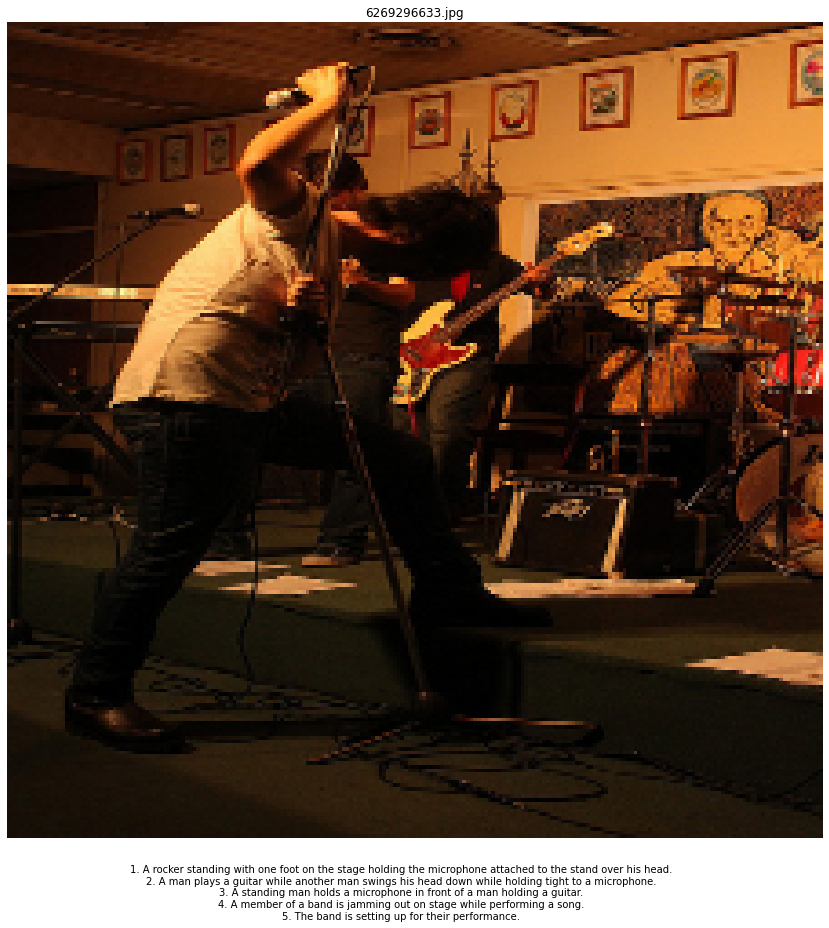

In [ ]:
dataset.visualize_item()

# Inference

In [ ]:
!mkdir /content/checkpoints
!gdown https://drive.google.com/uc?id=1ebQMcKCioE74MJXs8jpoL4WVvCFcb2RI -O /content/checkpoints/best.pth

Downloading...
From: https://drive.google.com/uc?id=1ebQMcKCioE74MJXs8jpoL4WVvCFcb2RI
To: /content/checkpoints/best.pth
100% 317M/317M [00:02<00:00, 143MB/s]


In [ ]:
%cd main
import torch
import faiss
from tools.configs import Config
from modules.models.encoder.modal import TERN
from tools.inference import make_query_embeddings, make_gallery_embeddings, faiss_search, show_retrieval


# Init model
device = torch.device('cuda')
config = Config('/content/main/tools/configs/yaml/tern.yaml')
config.model['args'].update({'precomp_bert': False})
model = TERN(**config.model['args'])
model.load_state_dict(torch.load('/content/checkpoints/best.pth')['model'])
model = model.to(device)
model.eval()

In [ ]:
# Init FAISS

res = faiss.StandardGpuResources()  # use a single GPU
faiss_pool = faiss.IndexFlatIP(config.model['args']['d_embed'])
faiss_pool = faiss.index_cpu_to_gpu(res, 0, faiss_pool)

In [ ]:
# Extract gallery embeddings
img_infos, gallery_embeddings = make_gallery_embeddings(
    ann_path = "/content/data/val.json", 
    feat_dir = "/content/data/bottom_up",
    model = model, device = device)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


1014it [00:04, 206.03it/s]


In [ ]:
# Embed query text

query_text = "two dogs are running along the street"
query_embeddings = make_query_embeddings(query_text, model, device)

In [ ]:
# Similarity search
top_k_indexes, top_k_scores = faiss_search(faiss_pool, query_embeddings, gallery_embeddings, top_k=10)

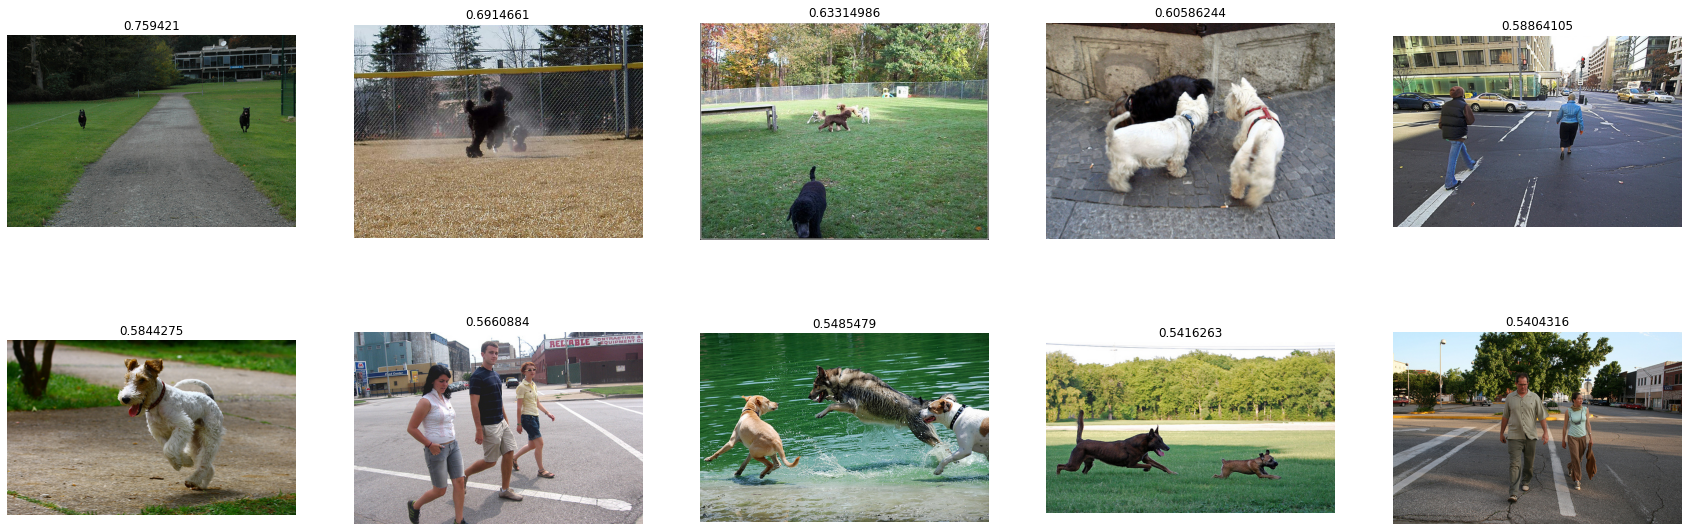

In [ ]:
# Show results

show_retrieval(
    "/content/data/flickr30k_images/flickr30k_images", 
    img_infos, top_k_indexes, top_k_scores)